In [ ]:
# http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/
# http://learningtensorflow.com/index.html
# http://suriyadeepan.github.io/2016-12-31-practical-seq2seq/

import tensorflow as tf
import numpy as np
from tensorflow.contrib import rnn
import pprint
pp = pprint.PrettyPrinter(indent=4)
sess = tf.InteractiveSession()

In [ ]:
# One hot encoding for each char in 'hello'
h = [1, 0, 0, 0]
e = [0, 1, 0, 0]
l = [0, 0, 1, 0]
o = [0, 0, 0, 1]

In [ ]:
with tf.variable_scope('one_cell') as scope:
    # One cell RNN input_dim (4) -> output_dim (2)
    hidden_size = 2
    cell = tf.keras.layers.SimpleRNNCell(units=hidden_size) # keras = tf를 더 쉽게 사용! 
    print(cell.output_size, cell.state_size)

    x_data = np.array([[h]], dtype=np.float32) # x_data = [[[1,0,0,0]]]
    pp.pprint(x_data)
    outputs, _states = tf.nn.dynamic_rnn(cell, x_data, dtype=tf.float32)

    sess.run(tf.global_variables_initializer())
    pp.pprint(outputs.eval())

In [ ]:
with tf.variable_scope('two_sequances') as scope:
    # One cell RNN input_dim (4) -> output_dim (2). sequence: 5
    hidden_size = 2
    cell = tf.keras.layers.SimpleRNNCell(units=hidden_size)
    x_data = np.array([[h, e, l, l, o]], dtype=np.float32) # 앞에서 선언한 변수 h, e, l, o  
    print(x_data.shape)
    pp.pprint(x_data)
    outputs, _states = tf.nn.dynamic_rnn(cell, x_data, dtype=tf.float32)
    sess.run(tf.global_variables_initializer())
    pp.pprint(outputs.eval())
    
# array안에 있는 값의 큰 의미는 없고, vector 화 되었다는 의미정도로 해석 할 것 

In [ ]:
with tf.variable_scope('3_batches') as scope:
    # One cell RNN input_dim (4) -> output_dim (2). sequence: 5, batch 3
    # 3 batches 'hello', 'eolll', 'lleel'
    x_data = np.array([[h, e, l, l, o],
                       [e, o, l, l, l],
                       [l, l, e, e, l]], dtype=np.float32)
    pp.pprint(x_data)
    
    hidden_size = 2
    cell = tf.nn.rnn_cell.LSTMCell(num_units=hidden_size, state_is_tuple=True)
    outputs, _states = tf.nn.dynamic_rnn(
        cell, x_data, dtype=tf.float32)
    sess.run(tf.global_variables_initializer())
    pp.pprint(outputs.eval())

### h,e,l,o RNN

In [ ]:
# Lab 12 RNN
import tensorflow as tf
import numpy as np
tf.set_random_seed(777)  # reproducibility

idx2char = ['h', 'i', 'e', 'l', 'o']
# Teach hello: hihell -> ihello
x_data = [[0, 1, 0, 2, 3, 3]]   # hihell
x_one_hot = [[[1, 0, 0, 0, 0],   # h 0
              [0, 1, 0, 0, 0],   # i 1
              [1, 0, 0, 0, 0],   # h 0
              [0, 0, 1, 0, 0],   # e 2
              [0, 0, 0, 1, 0],   # l 3
              [0, 0, 0, 1, 0]]]  # l 3

y_data = [[1, 0, 2, 3, 3, 4]]    # ihello

num_classes = 5
input_dim = 5  # one-hot size
hidden_size = 5  # output from the LSTM. 5 to directly predict one-hot
batch_size = 1   # one sentence
sequence_length = 6  # |ihello| == 6
learning_rate = 0.1

X = tf.placeholder(
    tf.float32, [None, sequence_length, input_dim])  # X one-hot
Y = tf.placeholder(tf.int32, [None, sequence_length])  # Y label

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True)
initial_state = cell.zero_state(batch_size, tf.float32)
outputs, _states = tf.nn.dynamic_rnn(
    cell, X, initial_state=initial_state, dtype=tf.float32)

# FC layer
X_for_fc = tf.reshape(outputs, [-1, hidden_size])
# fc_w = tf.get_variable("fc_w", [hidden_size, num_classes])
# fc_b = tf.get_variable("fc_b", [num_classes])
# outputs = tf.matmul(X_for_fc, fc_w) + fc_b
outputs = tf.contrib.layers.fully_connected(
    inputs=X_for_fc, num_outputs=num_classes, activation_fn=None)

# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])

weights = tf.ones([batch_size, sequence_length])
sequence_loss = tf.contrib.seq2seq.sequence_loss(
    logits=outputs, targets=Y, weights=weights)
loss = tf.reduce_mean(sequence_loss)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

prediction = tf.argmax(outputs, axis=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(50):
        l, _ = sess.run([loss, train], feed_dict={X: x_one_hot, Y: y_data})
        result = sess.run(prediction, feed_dict={X: x_one_hot})
        print(i, "loss:", l, "prediction: ", result, "true Y: ", y_data)

        # print char using dic
        result_str = [idx2char[c] for c in np.squeeze(result)]
        print("\tPrediction str: ", ''.join(result_str))

'''
0 loss: 1.71584 prediction:  [[2 2 2 3 3 2]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  eeelle
1 loss: 1.56447 prediction:  [[3 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  llllll
2 loss: 1.46284 prediction:  [[3 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  llllll
3 loss: 1.38073 prediction:  [[3 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  llllll
4 loss: 1.30603 prediction:  [[3 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  llllll
5 loss: 1.21498 prediction:  [[3 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  llllll
6 loss: 1.1029 prediction:  [[3 0 3 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  lhlllo
7 loss: 0.982386 prediction:  [[1 0 3 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihlllo
8 loss: 0.871259 prediction:  [[1 0 3 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihlllo
9 loss: 0.774338 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
10 loss: 0.676005 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello

...

'''

## Lab 12-2 many to one stacking
sentence sentiment classification

* many to one
* variable input sequence length
* stacking
* drop out

In [ ]:
# setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
%matplotlib inline

print(tf.__version__)
tf.enable_eager_execution() # eager_execution( 세션 호출 없이 바로바로 결과값을 확인할 수 있다.)

### preparing dataset

In [ ]:
# example data
sentences = ['What I cannot create, I do not understand.',
             'Intellecuals solve problems, geniuses prevent them',
             'A person who never made a mistake never tied anything new.',
             'The same equations have the same solutions.']
y_data = [1,0,0,1] # 1: richard feynman, 0: albert einstein

In [ ]:
# creating a token dictionary
char_set = ['<pad>'] + sorted(list(set(''.join(sentences))))
idx2char = {idx : char for idx, char in enumerate(char_set)}
char2idx = {char : idx for idx, char in enumerate(char_set)}

print(char_set)
print(idx2char)
print(char2idx)

In [ ]:
# converting sequence of tokens to sequence of indices
x_data = list(map(lambda sentence : [char2idx.get(char) for char in sentence], sentences))
x_data_len = list(map(lambda sentence : len(sentence), sentences))

print(x_data)
print(x_data_len)
print(y_data)

In [ ]:
# padding the sequence of indices
max_sequence = 55
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence,
                       padding = 'post', truncating = 'post')

# checking data
print(x_data)
print(x_data_len)
print(y_data)

### Creating Model

In [6]:
# creating stacked rnn for "many to one" classification with dropout
num_classes = 2
hidden_dims = [10,10]

input_dim = len(char2idx)
output_dim = len(char2idx)
one_hot = np.eye(len(char2idx))

model = Sequential()
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim,
                           trainable=False, mask_zero=True, input_length=max_sequence,
                           embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(layers.SimpleRNN(units=hidden_dims[0], return_sequences=True))
model.add(layers.TimeDistributed(layers.Dropout(rate = .2)))
model.add(layers.SimpleRNN(units=hidden_dims[1]))
model.add(layers.Dropout(rate = .2))
model.add(layers.Dense(units=num_classes))

In [7]:
model.summary()

### Training Model

In [8]:
# creating loss function
def loss_fn(model, x, y, training):
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=model(x, training))

# creating and optimizer
lr = .01
epochs = 30
batch_size = 2
opt = tf.train.AdamOptimizer(learning_rate = lr)

In [9]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size=batch_size)

print(tr_dataset)

In [10]:
# training
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb, training=True)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)
    
    if (epoch + 1) % 5 ==0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

### Checking performance

In [11]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1)
print('accuracy : {:.2%}'.format(np.mean(yhat == y_data)))

accuracy : 100.00%


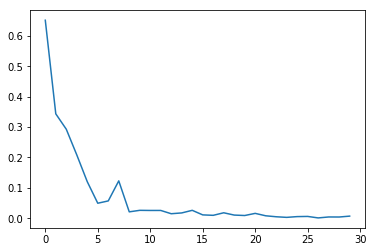

In [12]:
plt.plot(tr_loss_hist)